# HDFS Log Anomaly Detection - Part 1: EDA & Preprocessing

**Author**: AI-Based Log Anomaly Detection Team  
**Dataset**: HDFS_v1 from LogHub  
**Goal**: Download, parse, clean, and prepare HDFS logs for anomaly detection

---

## 1. Setup & Dependencies

Install required libraries and configure Google Drive access for Colab

In [1]:
# Install dependencies
!pip install -q pandas numpy matplotlib seaborn tqdm requests

# Import libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
import requests
from io import StringIO

warnings.filterwarnings('ignore')

# Configure visualization
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print('✓ Dependencies loaded successfully')
print(f'✓ Pandas version: {pd.__version__}')
print(f'✓ NumPy version: {np.__version__}')

✓ Dependencies loaded successfully
✓ Pandas version: 2.2.2
✓ NumPy version: 2.0.2


## 2. Mount Google Drive & Setup Directories

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Create project directories
base_path = '/content/drive/MyDrive/HDFS_Project/'
data_path = os.path.join(base_path, 'data')
results_path = os.path.join(base_path, 'results')

os.makedirs(data_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

print(f'✓ Google Drive mounted')
print(f'✓ Base path: {base_path}')
print(f'✓ Data path: {data_path}')
print(f'✓ Results path: {results_path}')

Mounted at /content/drive
✓ Google Drive mounted
✓ Base path: /content/drive/MyDrive/HDFS_Project/
✓ Data path: /content/drive/MyDrive/HDFS_Project/data
✓ Results path: /content/drive/MyDrive/HDFS_Project/results


## 3. Download HDFS_v1 Dataset from LogHub

This section downloads the HDFS_v1 dataset from the LogHub repository

In [3]:
from google.colab import files
files.upload()
# config de kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#charger dateset
!kaggle datasets download -d ayenuryrr/loghub-hdfs-hadoop-distributed-file-system-data
!unzip -q loghub-hdfs-hadoop-distributed-file-system-data.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ayenuryrr/loghub-hdfs-hadoop-distributed-file-system-data
License(s): Attribution 4.0 International (CC BY 4.0)
 98% 1.53G/1.55G [00:20<00:00, 248MB/s]
100% 1.55G/1.55G [00:20<00:00, 81.5MB/s]


In [4]:
# Download datasets
log_file ="/content/HDFS_v1/HDFS.log"
label_file = "/content/HDFS_v1/preprocessed/anomaly_label.csv"

## 4. Parse and Load Raw Data

In [12]:
import re
import pandas as pd
from tqdm import tqdm

def parse_hdfs_log_limited(log_file_path, limit=1000000):
    # Pattern HDFS_v1 : Date Time PID Level Component: Message
    pattern = r'^(\d{6})\s+(\d{6})\s+(\d+)\s+(\w+)\s+([\w\.\$\d]+):\s+(.*)$'

    logs = []
    failed_lines = 0

    print(f'Parsing HDFS log file (Limité à {limit:,} lignes)...')

    with open(log_file_path, 'r', encoding='utf-8', errors='ignore') as f:
        # On utilise enumerate pour compter les lignes lues
        for i, line in tqdm(enumerate(f), total=limit, desc='Parsing logs'):
            if i >= limit:
                break # On s'arrête exactement à 5 millions

            line = line.strip()
            if not line: continue

            match = re.match(pattern, line)
            if match:
                date, time, pid, level, component, message = match.groups()

                # Extraction du BlockID
                block_match = re.search(r'(blk_-?\d+)', message)
                block_id = block_match.group(1) if block_match else None # None au lieu de "Unknown" pour faciliter le dropna plus tard

                logs.append({
                    'timestamp': f"{date}_{time}",
                    'log_level': level,
                    'component': component,
                    'message': message,
                    'BlockId': block_id
                })
            else:
                failed_lines += 1

    df_logs = pd.DataFrame(logs)
    print(f'\nSuccès : {len(df_logs):,} logs extraits')
    print(f'Échecs : {failed_lines:,} lignes ignorées')

    return df_logs

# Exécution du parsing
df = parse_hdfs_log_limited(log_file, limit=5000000)

Parsing HDFS log file (Limité à 5,000,000 lignes)...


Parsing logs: 100%|██████████| 5000000/5000000 [00:30<00:00, 161810.18it/s]



Succès : 5,000,000 logs extraits
Échecs : 0 lignes ignorées


## 5. Load Anomaly Labels


In [13]:
# Load anomaly labels
df_labels = pd.read_csv(label_file)

print(f'Anomaly labels shape: {df_labels.shape}')
print(f'\nLabel columns: {df_labels.columns.tolist()}')
print(f'\nFirst 5 labels:')
print(df_labels.head())
print(f'\nLabel distribution:')
print(df_labels['Label'].value_counts())

Anomaly labels shape: (575061, 2)

Label columns: ['BlockId', 'Label']

First 5 labels:
                    BlockId    Label
0  blk_-1608999687919862906   Normal
1   blk_7503483334202473044   Normal
2  blk_-3544583377289625738  Anomaly
3  blk_-9073992586687739851   Normal
4   blk_7854771516489510256   Normal

Label distribution:
Label
Normal     558223
Anomaly     16838
Name: count, dtype: int64


## 6. Extract BlockId from Messages



In [14]:
def extract_blockid(message):
    """Extract BlockId from HDFS log message"""
    # Pattern: blk_-123456789
    match = re.search(r'blk_-?\d+', str(message))
    if match:
        return match.group(0)
    return None

print('Extracting BlockId from messages...')
df['BlockId'] = df['message'].apply(extract_blockid)

# Statistics
total_logs = len(df)
logs_with_blockid = df['BlockId'].notna().sum()
coverage = (logs_with_blockid / total_logs) * 100

print(f'✓ Total logs: {total_logs:,}')
print(f'✓ Logs with BlockId: {logs_with_blockid:,}')
print(f'✓ BlockId coverage: {coverage:.2f}%')
print(f'✓ Unique BlockIds: {df["BlockId"].nunique():,}')

# Show sample BlockIds
print(f'\nSample BlockIds:')
print(df[df['BlockId'].notna()]['BlockId'].head(10).tolist())

Extracting BlockId from messages...
✓ Total logs: 5,000,000
✓ Logs with BlockId: 5,000,000
✓ BlockId coverage: 100.00%
✓ Unique BlockIds: 243,173

Sample BlockIds:
['blk_-1608999687919862906', 'blk_-1608999687919862906', 'blk_-1608999687919862906', 'blk_-1608999687919862906', 'blk_-1608999687919862906', 'blk_-1608999687919862906', 'blk_-1608999687919862906', 'blk_-1608999687919862906', 'blk_-1608999687919862906', 'blk_-1608999687919862906']


## 7. Data Cleaning & Preprocessing



In [15]:
# 1. Filtrage immédiat (Memory Management)
# On ne garde que les logs utiles pour l'IA
initial_len = len(df)
df = df.dropna(subset=['BlockId']).copy()
print(f"Logs sans BlockId supprimés : {initial_len - len(df):,}")

# 2. Conversion temporelle sécurisée
# On utilise 'errors=coerce' pour éviter que tout le script plante si une ligne est mal formatée
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%y%m%d_%H%M%S', errors='coerce')

# On supprime les quelques lignes où la date n'a pas pu être convertie (si elles existent)
df = df.dropna(subset=['timestamp'])

# 3. Déduplication intelligente
# On considère un doublon si le message ET le moment ET le bloc sont identiques
df = df.drop_duplicates(subset=['timestamp', 'BlockId', 'message'])
print(f"Dataset après déduplication : {len(df):,} lignes")

# 4. Nettoyage du texte (Indispensable pour le Notebook 02)
# On met tout en minuscule et on enlève les espaces inutiles pour que l'IA ne fasse pas de différence
# entre "Error" et "error"
df['message'] = df['message'].str.lower().str.strip()

# 5. Typage des données (Réduit l'utilisation de la RAM)
# Convertir le log_level en 'category' au lieu de 'object' (texte) divise par 4 sa taille en mémoire
df['log_level'] = df['log_level'].astype('category')

print(f"\nPrêt pour l'étape suivante ! Taille finale : {df.shape}")

Logs sans BlockId supprimés : 0
Dataset après déduplication : 4,791,517 lignes

Prêt pour l'étape suivante ! Taille finale : (4791517, 5)


## 8. Exploratory Data Analysis (EDA)

Log Level Distribution:
log_level
INFO    4459476
WARN     332041
Name: count, dtype: int64


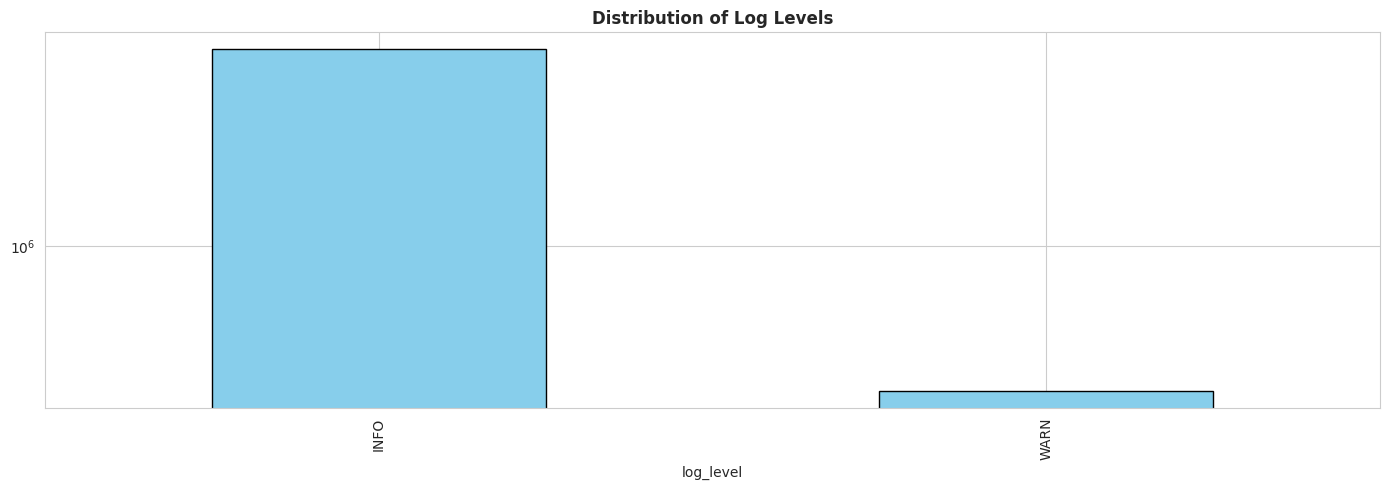

In [16]:
import matplotlib.pyplot as plt
import os

# Vérification si la colonne 'thread' existe avant de tracer
has_thread = 'thread' in df.columns

# Log level distribution
print('Log Level Distribution:')
print(df['log_level'].value_counts())

# Visualize
fig, axes = plt.subplots(1, 2 if has_thread else 1, figsize=(14, 5))

# Log level bar chart (Toujours présent)
ax0 = axes[0] if has_thread else axes
df['log_level'].value_counts().plot(kind='bar', ax=ax0, color='skyblue', edgecolor='black')
ax0.set_title('Distribution of Log Levels', fontweight='bold')
ax0.set_yscale('log') # Très important car INFO écrase souvent WARN visuellement

if has_thread:
    # Thread distribution (top 10)
    df['thread'].value_counts().head(10).plot(kind='barh', ax=axes[1], color='lightcoral', edgecolor='black')
    axes[1].set_title('Top 10 Most Active Threads', fontweight='bold')

plt.tight_layout()
# S'assurer que le dossier existe avant de sauvegarder
if not os.path.exists(results_path):
    os.makedirs(results_path)
plt.savefig(os.path.join(results_path, 'log_distribution.png'))
plt.show()

## 9. Temporal Analysis

Time range: 1 days 01:17:22
Start time: 2008-11-09 20:35:18
End time: 2008-11-10 21:52:40


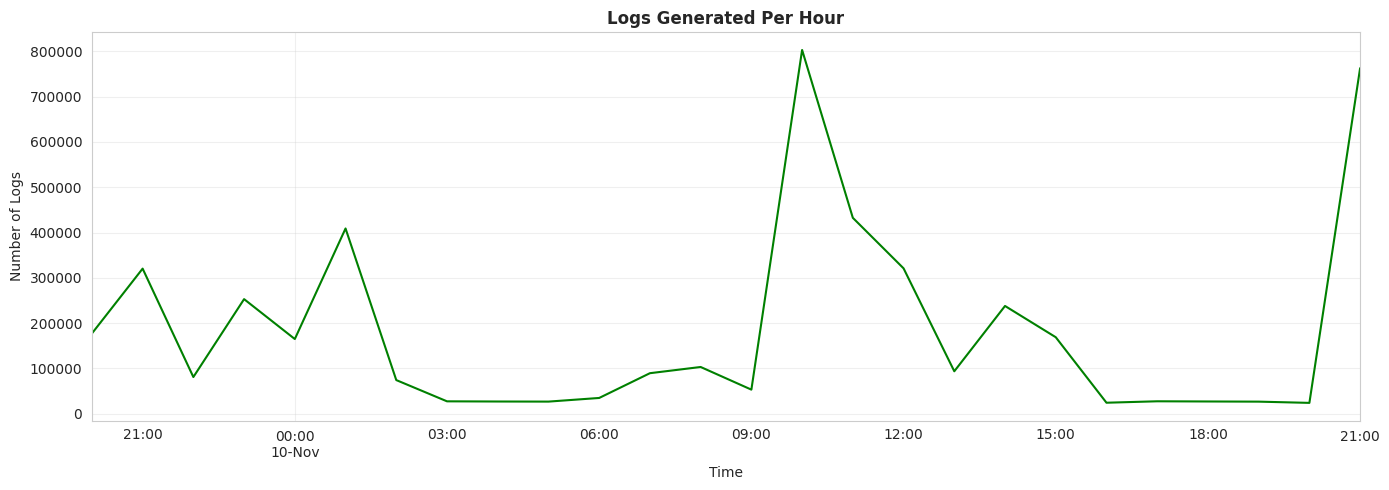

✓ Average logs per hour: 184289.12
✓ Max logs per hour: 803026
✓ Min logs per hour: 23993


In [17]:
# Time range
time_range = df['timestamp'].max() - df['timestamp'].min()
print(f'Time range: {time_range}')
print(f'Start time: {df["timestamp"].min()}')
print(f'End time: {df["timestamp"].max()}')

# Logs per hour
df['hour'] = df['timestamp'].dt.floor('H')
logs_per_hour = df.groupby('hour').size()

fig, ax = plt.subplots(figsize=(14, 5))
logs_per_hour.plot(ax=ax, color='green', linewidth=1.5)
ax.set_title('Logs Generated Per Hour', fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Number of Logs')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(results_path, 'temporal_distribution.png'), dpi=100, bbox_inches='tight')
plt.show()

print(f'✓ Average logs per hour: {logs_per_hour.mean():.2f}')
print(f'✓ Max logs per hour: {logs_per_hour.max()}')
print(f'✓ Min logs per hour: {logs_per_hour.min()}')

## 10. Session (Block) Analysis

Analyzing sessions (BlockIds)...
✓ Total unique sessions: 243,173

Session statistics:
count    243173.000000
mean         19.704149
std           6.141837
min           1.000000
25%          16.000000
50%          18.000000
75%          23.000000
max         274.000000
Name: log_count, dtype: float64


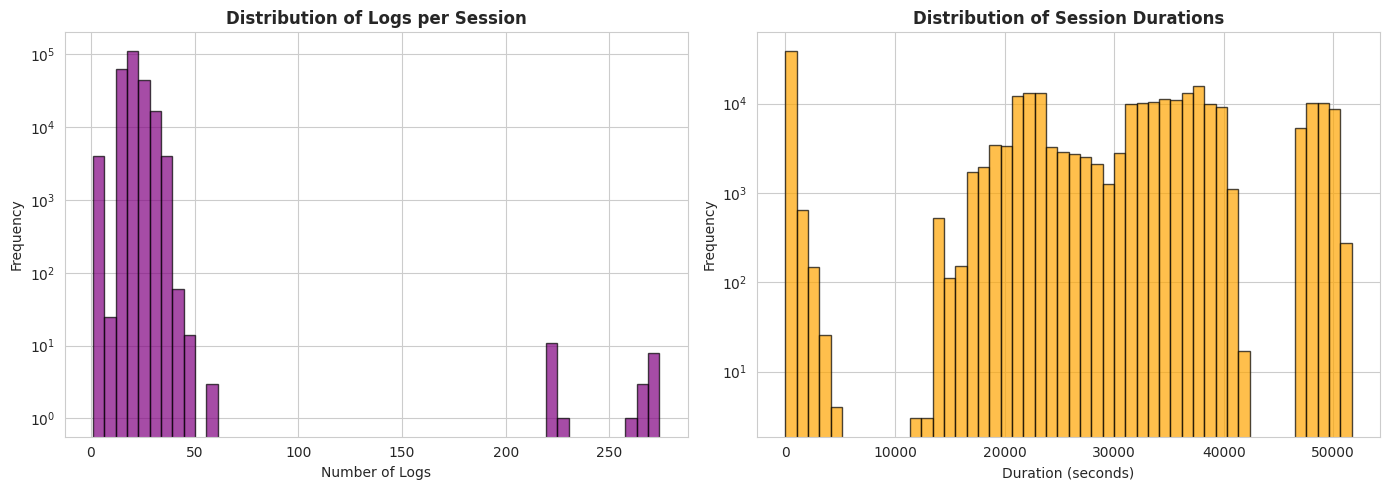

In [18]:
# Group by BlockId to create sessions
print('Analyzing sessions (BlockIds)...')
session_stats = df.groupby('BlockId').agg({
    'message': 'count',
    'timestamp': ['min', 'max']
}).reset_index()

session_stats.columns = ['BlockId', 'log_count', 'start_time', 'end_time']
session_stats['duration_seconds'] = (session_stats['end_time'] - session_stats['start_time']).dt.total_seconds()

print(f'✓ Total unique sessions: {len(session_stats):,}')
print(f'\nSession statistics:')
print(session_stats['log_count'].describe())

# Visualize session distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Logs per session histogram
axes[0].hist(session_stats['log_count'], bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Logs per Session', fontweight='bold')
axes[0].set_xlabel('Number of Logs')
axes[0].set_ylabel('Frequency')
axes[0].set_yscale('log')

# Session duration histogram
axes[1].hist(session_stats['duration_seconds'], bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribution of Session Durations', fontweight='bold')
axes[1].set_xlabel('Duration (seconds)')
axes[1].set_ylabel('Frequency')
axes[1].set_yscale('log')

plt.tight_layout()
plt.savefig(os.path.join(results_path, 'session_distribution.png'), dpi=100, bbox_inches='tight')
plt.show()

## 11. Merge with Anomaly Labels

Class Distribution:
Label
Normal     4650967
Anomaly     140550
Name: count, dtype: int64

Percentage:
Label
Normal     97.07
Anomaly     2.93
Name: count, dtype: float64


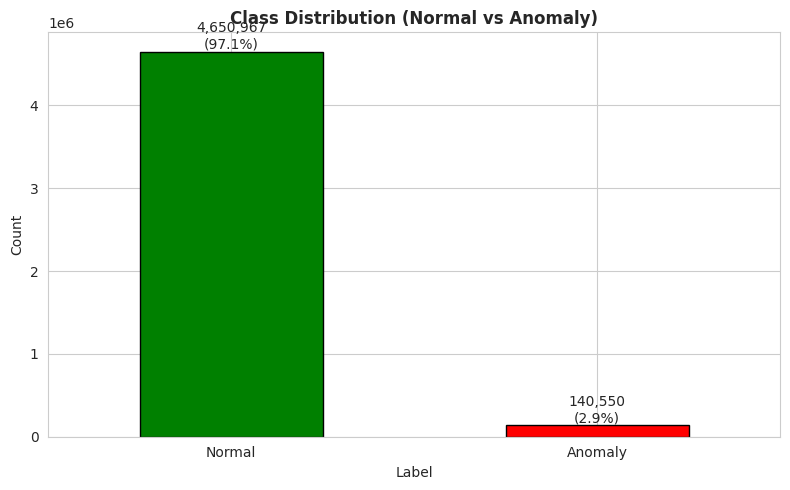

In [19]:
# Merge logs with anomaly labels
df = df.merge(df_labels, on='BlockId', how='left')

# Fill missing labels with 'Normal'
df['Label'] = df['Label'].fillna('Normal')

# Statistics
print('Class Distribution:')
class_dist = df['Label'].value_counts()
print(class_dist)
print(f'\nPercentage:')
print((class_dist / len(df) * 100).round(2))

# Visualize class distribution
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['green', 'red']
class_dist.plot(kind='bar', ax=ax, color=colors[:len(class_dist)], edgecolor='black')
ax.set_title('Class Distribution (Normal vs Anomaly)', fontweight='bold', fontsize=12)
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=0)

# Add count labels on bars
for i, v in enumerate(class_dist):
    ax.text(i, v, f'{v:,}\n({v/len(df)*100:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(results_path, 'class_distribution.png'), dpi=100, bbox_inches='tight')
plt.show()

## 12. Save Preprocessed Data

In [20]:
# Save preprocessed data
output_file = os.path.join(data_path, 'hdfs_v1_preprocessed.csv')
df.to_csv(output_file, index=False)

print(f'✓ Preprocessed data saved to:')
print(f'  {output_file}')
print(f'\n✓ File size: {os.path.getsize(output_file) / (1024*1024):.2f} MB')
print(f'\n✓ Dataset shape: {df.shape}')
print(f'\n✓ Columns: {df.columns.tolist()}')

# Create summary report
summary = f"""HDFS v1 PREPROCESSING SUMMARY
{'='*60}
Dataset: HDFS_v1 (LogHub)

STATISTICS:
  Total logs: {len(df):,}
  Unique BlockIds: {df['BlockId'].nunique():,}
  Time range: {time_range}

CLASS DISTRIBUTION:
  Normal: {(df['Label'] == 'Normal').sum():,} ({(df['Label'] == 'Normal').sum()/len(df)*100:.2f}%)
  Anomaly: {(df['Label'] == 'Anomaly').sum():,} ({(df['Label'] == 'Anomaly').sum()/len(df)*100:.2f}%)

LOG LEVEL DISTRIBUTION:
{df['log_level'].value_counts().to_string()}

OUTPUT:
  File: {output_file}
  Shape: {df.shape}
  Columns: {len(df.columns)}

{'='*60}
"""

# Save summary
summary_file = os.path.join(results_path, 'preprocessing_summary.txt')
with open(summary_file, 'w') as f:
    f.write(summary)

print(summary)

✓ Preprocessed data saved to:
  /content/drive/MyDrive/HDFS_Project/data/hdfs_v1_preprocessed.csv

✓ File size: 874.06 MB

✓ Dataset shape: (4791517, 7)

✓ Columns: ['timestamp', 'log_level', 'component', 'message', 'BlockId', 'hour', 'Label']
HDFS v1 PREPROCESSING SUMMARY
Dataset: HDFS_v1 (LogHub)

STATISTICS:
  Total logs: 4,791,517
  Unique BlockIds: 243,173
  Time range: 1 days 01:17:22
  
CLASS DISTRIBUTION:
  Normal: 4,650,967 (97.07%)
  Anomaly: 140,550 (2.93%)
  
LOG LEVEL DISTRIBUTION:
log_level
INFO    4459476
WARN     332041

OUTPUT:
  File: /content/drive/MyDrive/HDFS_Project/data/hdfs_v1_preprocessed.csv
  Shape: (4791517, 7)
  Columns: 7




## 13. Next Steps
- Statistical features (message length, word count, etc.)
- Pattern-based features (templates, keyword frequencies)
- Categorical encodings (log levels, sessions)
- Normalized feature matrix for ML models